## Initial analysis

In [1]:
# Install the required libraries (from pip_requirements.txt)
%pip install -r pip_requirements.txt

!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 9.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 8.4 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 8.7 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 5.2 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 5.0 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 4.4 MB/s eta 0:00:02
     ---------------------- ----------------- 7.1/12.8 MB 4.9 MB/s eta 0:00:02
     --------------------------- ------------ 8.7/12.8 MB 5.2 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 5.5 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 5.7 MB/s eta 0:00:0

In [2]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from importlib import reload

In [3]:
paths = ['src/data','src/models','src/scripts','src/utils']
for path in paths:
    sys.path.append(path)

## I. Data preprocessing

### I.1 Original data

In [4]:
# Execute dataCleaning.py
# This script create dictionaries of freebase_id, convert date to datetime object, transform our columns

%run src/scripts/dataCleaning.py

Movies successfully loaded
Characters successfully loaded
Clusters successfully loaded
Summaries successfully loaded
Dates successfully converted
Build of countries dictionnary...
Build of languages dictionnary...
Build of genres dictionnary...
Build of actors dictionnary...
Build of character dictionnary...
Build of movies dictionnary...
Dictionnaries successfully saved
Saved movies_cleaned to data/cleanData/movies_cleaned.csv
Saved characters_cleaned to data/cleanData/characters_cleaned.csv
Saved character_clusters_cleaned to data/cleanData/character_clusters_cleaned.csv
Saved summaries_cleaned to data/cleanData/summaries_cleaned.csv
Datasets successfully saved
Data cleaning successfully done


Load the data

In [5]:
# Import dataloader function
from dataLoader import loadDataframe

In [6]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


### I.2 Additional data

#### I.2.1 Additional movie dataset from Kaggle

Because the revenue is important for the Economics part of our analysis we try to add a new dataset from Kaggle with movies to add more consistency to our results.

The new dataset has the revenue and the budget as interesting features for the Economics analysis.

In [7]:
#Execute additionaldataCleaning.py
#This script create dictionaries of freebase_id, convert date to datetime object, transform our columns TO CHANGE

%run src/scripts/additionaldataCleaning.py

Additional Movies successfully loaded
Monthly inflation data successfully loaded
Budget successfully converted
Filtered additional movie data successfully created
Inflation data successfully processed
Saved Kaggle_US_CPI_monthly_cleaned to data/cleanData/Kaggle_US_CPI_monthly_cleaned.csv
Saved monthly inflation data to Kaggle_US_CPI_monthly_cleaned.csv
Saved Kaggle_US_CPI_annual_cleaned to data/cleanData/Kaggle_US_CPI_annual_cleaned.csv
Saved annual inflation data to Kaggle_US_CPI_annual_cleaned.csv
Saved Kaggle_movie_data_tmdb_cleaned to data/cleanData/Kaggle_movie_data_tmdb_cleaned.csv
Saved additional movie data to Kaggle_movie_data_tmdb_cleaned.csv
Saved Kaggle_movie_data_tmdb_filtered_cleaned to data/cleanData/Kaggle_movie_data_tmdb_filtered_cleaned.csv
Saved filtered additional movie data to Kaggle_movie_data_tmdb_filtered_cleaned.csv


Data statistics overview

In [8]:
from dataLoader import loadAdditionalDataframe

In [9]:
df_inflation_additional_annual = loadAdditionalDataframe('inflation_annual', path_to_directory)
df_inflation_additional_monthly = loadAdditionalDataframe('inflation_monthly', path_to_directory)  
df_movies_additional = loadAdditionalDataframe('movies_additional', path_to_directory)
df_movies_additional_filtered = loadAdditionalDataframe('movies_additional_filtered', path_to_directory)

In [10]:
df_movies_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119931 entries, 0 to 119930
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   imdb_id            114475 non-null  object 
 1   original_title     119392 non-null  object 
 2   original_language  119392 non-null  object 
 3   budget             119074 non-null  float64
 4   revenue            119071 non-null  object 
 5   release_date       118642 non-null  object 
 6   title              118752 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.4+ MB


In [11]:
# Non null values proportion
df_movies_additional.isnull().mean()

imdb_id              0.045493
original_title       0.004494
original_language    0.004494
budget               0.007146
revenue              0.007171
release_date         0.010748
title                0.009831
dtype: float64

The features that we are interested in are the following:
- 'original_title' : more than 99% of the movies have a title
- 'revenue' : more than 99% of the movies have a revenue
- 'budget' : more than 99% of the movies have a budget

So we have a large amount of non null values that we can use to make our economics analysis.

In [12]:
from generalUtils import intersectionId

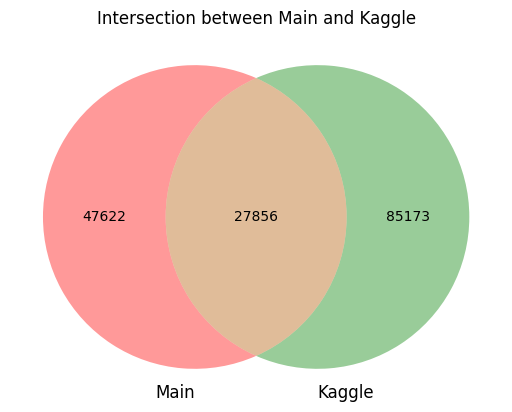

In [13]:
intersectionId(df_movies, df_movies_additional, 'Main', 'Kaggle', id_column='original_title')

More than 27,000 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

In [14]:
df_movies_additional.loc[df_movies_additional['budget'] != 0].count()

imdb_id              14391
original_title       14504
original_language    14504
budget               14186
revenue              14496
release_date         14431
title                14178
dtype: int64

However, after a deeper analysis on the Kaggle dataset we realize that only ~14,000 values are not null for the budget and the revenue. So, a lot of implicit missing values were hidden in the Kaggle dataset.

Additional movie data from Kaggle where budget is not null

In [15]:
df_movies_additional_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15043 entries, 0 to 15042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_id            14391 non-null  object 
 1   original_title     14504 non-null  object 
 2   original_language  14504 non-null  object 
 3   budget             14186 non-null  float64
 4   revenue            14496 non-null  object 
 5   release_date       14431 non-null  object 
 6   title              14178 non-null  object 
dtypes: float64(1), object(6)
memory usage: 822.8+ KB


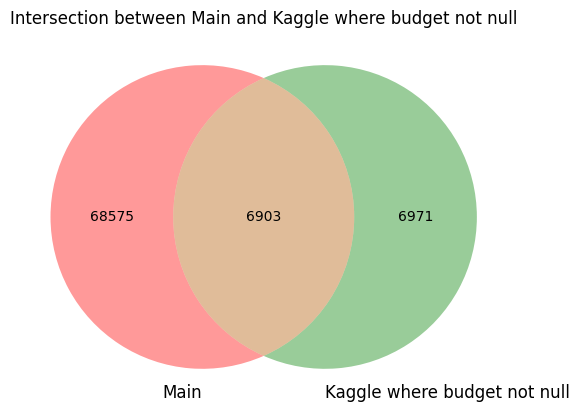

In [16]:
intersectionId(df_movies, df_movies_additional_filtered, 'Main', 'Kaggle where budget not null', id_column='original_title')

Finally, we realize that only 6,903 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

This is much lower than we had hoped, which makes the dataset irrelevant in our case, as the feature revenue of the original dataset had 8401 non-zero values.

### I.2.2 Inflation dataset from Kaggle

Because we are going to study the revenue of movies it is also important to consider the Inflation by importing a dataset from Kaggle. Without adjusting for inflation, raw revenue data can be misleading, underestimating or overestimating the relative success of films from past eras. Adjusting for inflation makes analyses much more relevant and nuanced for understanding the evolution of the film industry. We make the assumption that the Consumer Price Index of the USA is representative of the rest of the world.

In [17]:
df_inflation_additional_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Yearmon  1296 non-null   datetime64[ns]
 1   CPI      1296 non-null   float64       
 2   year     1296 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 25.4 KB


In [18]:
df_inflation_additional_annual.describe()

year         CPI
count   108.00000  108.000000
mean   1966.50000   81.641431
std      31.32092   79.760606
min    1913.00000    9.883333
25%    1939.75000   17.495833
50%    1966.50000   32.908333
75%    1993.25000  145.400000
max    2020.00000  258.811167

The annual inflation dataset from 1913 to 2020 will be used to readjust the revenue of movies considering the year of release.

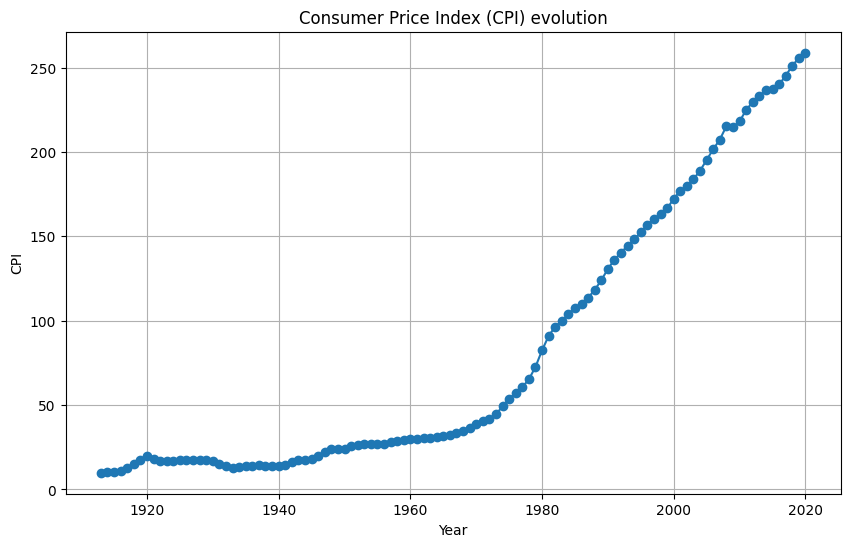

In [19]:
# plot the temporal evolution of the Consumer Price Index (CPI)
plt.figure(figsize=(10, 6))
plt.plot(df_inflation_additional_annual['year'], df_inflation_additional_annual['CPI'], marker='o')
plt.title('Consumer Price Index (CPI) evolution')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.grid()
plt.show()


## III. Economics

### III.1 Dataframe for Economics part

Filtering on notna box office revenue

In [20]:
df_movies_eco = df_movies[df_movies['revenue'].notna()]
df_movies_eco['year'] = df_movies_eco['release_date'].dt.year
df_movies_eco.describe()

C:\Users\aurel\AppData\Local\Temp\ipykernel_18068\306766949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_eco['year'] = df_movies_eco['release_date'].dt.year


wiki_id                   release_date       revenue      runtime  \
count  8.401000e+03                           8328  8.401000e+03  8302.000000   
mean   9.138449e+06  1991-06-28 21:27:39.942363136  4.799363e+07   105.579583   
min    3.217000e+03            1897-05-22 00:00:00  1.000000e+04    10.000000   
25%    1.231856e+06            1984-12-29 06:00:00  2.083193e+06    93.000000   
50%    4.143564e+06            1997-09-06 00:00:00  1.063969e+07   102.000000   
75%    1.521043e+07            2006-06-23 00:00:00  4.071696e+07   114.000000   
max    3.706127e+07            2012-10-25 00:00:00  2.782275e+09  1003.000000   
std    1.025119e+07                            NaN  1.121753e+08    23.503176   

              year  
count  8328.000000  
mean   1991.056076  
min    1897.000000  
25%    1984.750000  
50%    1997.000000  
75%    2006.000000  
max    2012.000000  
std      19.728927

To carry out our study we will be able to rely on 8401 non-zero income values.

Recalculating box office revenue indexed to US inflation

<Axes: xlabel='year'>

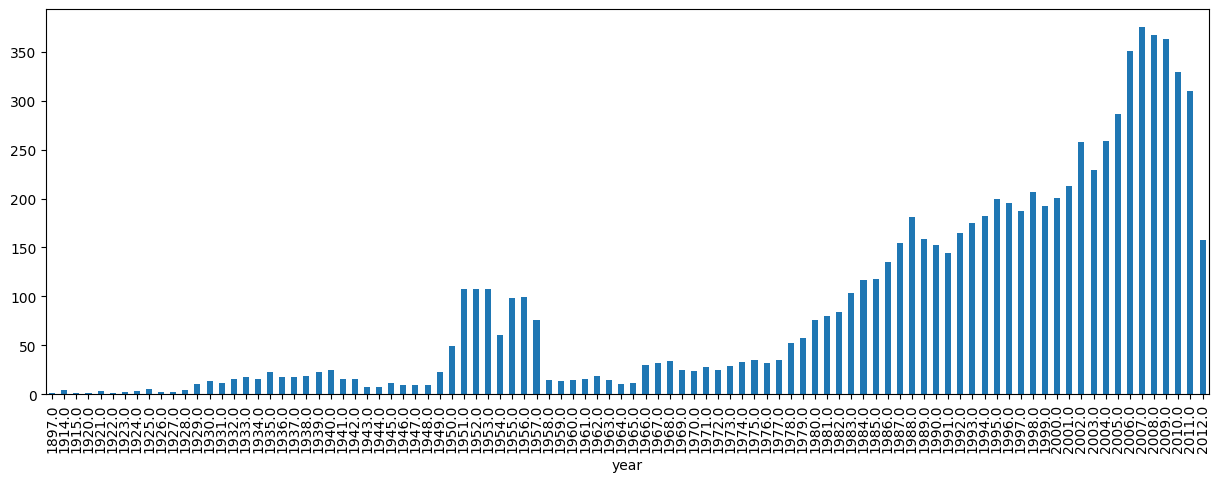

In [21]:
df_movies_eco['year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

Income values in the orignal dataset range from 1897 to 2012 with only one value in 1897. So, considering the CPI dataset ranges from 1914 to 2020, we remove the first revenue value and null values.

In [22]:
df_movies_eco = df_movies_eco.dropna(subset=['year'])
df_movies_eco = df_movies_eco[df_movies_eco['year'] != 1897]
df_movies_eco['revenue'].notnull().sum()


np.int64(8327)

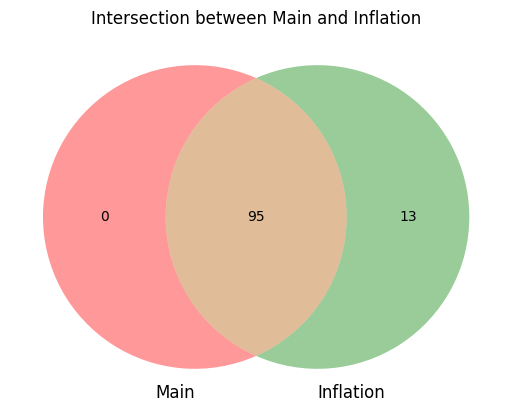

In [23]:
intersectionId(df_movies_eco, df_inflation_additional_annual, 'Main', 'Inflation', id_column='year')

Finally, the Economic analysis is conducted on a sample of 8327 movies. We notice that all the years of the selected sample of 8327 movies have a correspondance in the inflation dataset. So, we are able to calculate the income reindexed for inflation, using the midpoint year between 2012 and 1914 as a reference year (1963 in this case) to minimize edge effects.








In [24]:
reference_year = 1963
cpi_reference = df_inflation_additional_annual[df_inflation_additional_annual['year'] == reference_year]['CPI'].values[0]
df_movies_eco['revenue_adj'] = df_movies_eco.apply(lambda x: x['revenue'] * cpi_reference / df_inflation_additional_annual[df_inflation_additional_annual['year'] == x['year']]['CPI'].values[0], axis=1)

In [25]:
df_movies_eco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8327 entries, 0 to 81732
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                8327 non-null   int64         
 1   freebase_id            8327 non-null   object        
 2   original_title         8327 non-null   object        
 3   release_date           8327 non-null   datetime64[ns]
 4   revenue                8327 non-null   float64       
 5   runtime                8243 non-null   float64       
 6   languages              8327 non-null   object        
 7   countries              8327 non-null   object        
 8   genres                 8327 non-null   object        
 9   countries_freebase_id  8327 non-null   object        
 10  languages_freebase_id  8327 non-null   object        
 11  genres_freebase_id     8327 non-null   object        
 12  year                   8327 non-null   float64       
 13  revenue

### III.2 Free exchange of goods and services

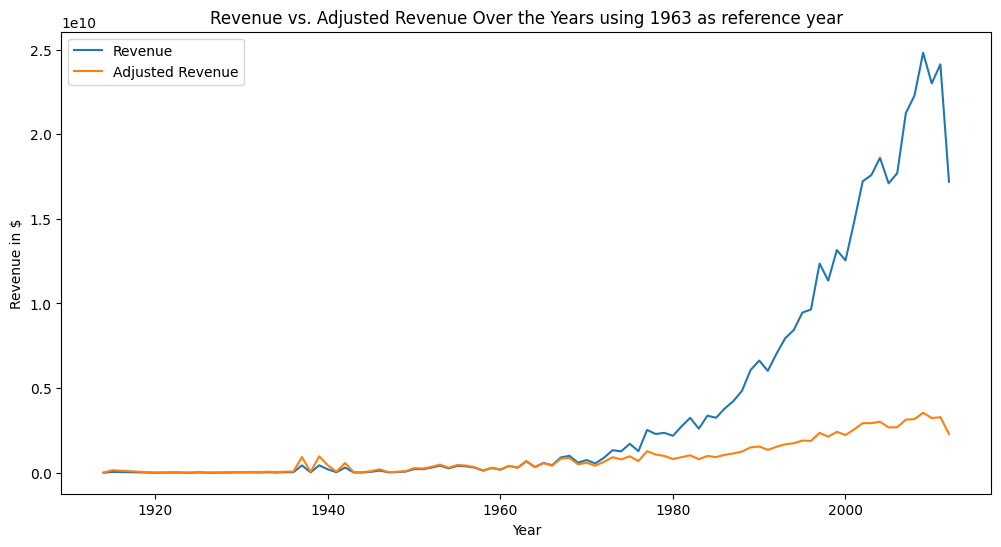

In [26]:
# plot the revenue vs. adjusted revenue over the years
plt.figure(figsize=(12, 6))
plt.plot(df_movies_eco.groupby('year')['revenue'].sum(), label='Revenue')
plt.plot(df_movies_eco.groupby('year')['revenue_adj'].sum(), label='Adjusted Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue in $')
plt.title('Revenue vs. Adjusted Revenue Over the Years using 1963 as reference year')
plt.legend()


From the previous plot we observe that the computation of the value of revenue adjusted for inflation is an essential indicator for correctly interpreting the evolution of film revenues over a long period, in the context of the film industry from 1914 to 2012. we can confirm that using 1963 as the reference year helps to minimize potential edge effects that might have appeared if a more recent or much older year were used.

Observations:

   - The orange line remains relatively flat, suggesting that when adjusted to 1963 dollars, the revenue of movies has not significantly increased over time. This could imply that the apparent increase in revenue is primarily due to inflation rather than a true increase in movie profitability.
    
   - The blue line rises especially from the 1980s, reflecting an increase in nominal revenue, likely driven by more films produced higher ticket prices, broader audiences, and expanding international markets.

Finally, we can state that it is possible to address the topic of free trade in goods and services, by examining the box office revenue of films over time and potentially by splitting by country.

In [27]:
def transformCountryNameGpd(countries_freebase_id):
    # Load countries dictionnary
    with open('././data/freebaseIdDictionnaries/countries_geo', 'r') as file:
        countries_dict = json.load(file)
    
    # Transform countries names to geopandas names using the freebase id
    countries_name = []
    n = len(countries_freebase_id)
    for i in range(n):
        country_freebase_id = countries_freebase_id[i]
        country_name = countries_dict[country_freebase_id]
        countries_name.append(country_name)
    
    return countries_name

In [28]:
df_movies_eco['countries'] = df_movies_eco['countries_freebase_id'].apply(transformCountryNameGpd)


In [29]:
df_movies_eco[df_movies_eco['countries'].apply(lambda x: len(x) == 0)].count()

wiki_id                  99
freebase_id              99
original_title           99
release_date             99
revenue                  99
runtime                  75
languages                99
countries                99
genres                   99
countries_freebase_id    99
languages_freebase_id    99
genres_freebase_id       99
year                     99
revenue_adj              99
dtype: int64

In [ ]:
df_movies_eco = df_movies_eco[df_movies_eco['countries'] != 'nan']

In [30]:
#we create duplicates of the rows with multiple production countries
df_movies_eco_exploded_countries = df_movies_eco.explode('countries')

In [47]:
df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == 'nan'].count()

wiki_id                  99
freebase_id              99
original_title           99
release_date             99
revenue                  99
runtime                  75
languages                99
countries                99
genres                   99
countries_freebase_id    99
languages_freebase_id    99
genres_freebase_id       99
year                     99
revenue_adj              99
dtype: int64

In [48]:
df_movies_eco_exploded_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11084 entries, 0 to 81732
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                11084 non-null  int64         
 1   freebase_id            11084 non-null  object        
 2   original_title         11084 non-null  object        
 3   release_date           11084 non-null  datetime64[ns]
 4   revenue                11084 non-null  float64       
 5   runtime                10993 non-null  float64       
 6   languages              11084 non-null  object        
 7   countries              11084 non-null  object        
 8   genres                 11084 non-null  object        
 9   countries_freebase_id  11084 non-null  object        
 10  languages_freebase_id  11084 non-null  object        
 11  genres_freebase_id     11084 non-null  object        
 12  year                   11084 non-null  float64       
 13  revenu

In [ ]:
df_movies_eco_exploded_countries = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] != 'nan']

In [51]:
df_movies_eco_exploded_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10985 entries, 0 to 81726
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                10985 non-null  int64         
 1   freebase_id            10985 non-null  object        
 2   original_title         10985 non-null  object        
 3   release_date           10985 non-null  datetime64[ns]
 4   revenue                10985 non-null  float64       
 5   runtime                10918 non-null  float64       
 6   languages              10985 non-null  object        
 7   countries              10985 non-null  object        
 8   genres                 10985 non-null  object        
 9   countries_freebase_id  10985 non-null  object        
 10  languages_freebase_id  10985 non-null  object        
 11  genres_freebase_id     10985 non-null  object        
 12  year                   10985 non-null  float64       
 13  revenu

In [52]:
df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == 'nan'].count()

wiki_id                  0
freebase_id              0
original_title           0
release_date             0
revenue                  0
runtime                  0
languages                0
countries                0
genres                   0
countries_freebase_id    0
languages_freebase_id    0
genres_freebase_id       0
year                     0
revenue_adj              0
dtype: int64

First try to split by country with a specific one

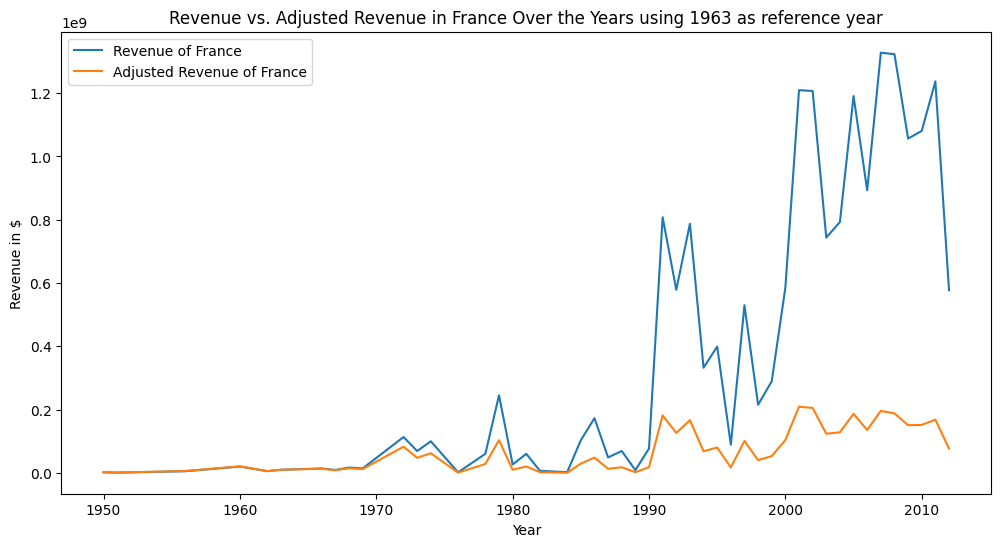

In [53]:
# plot the revenue vs. adjusted revenue over the years
plt.figure(figsize=(12, 6))
plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == 'France'].groupby('year')['revenue'].sum(), label='Revenue of France')
plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == 'France'].groupby('year')['revenue_adj'].sum(), label='Adjusted Revenue of France')
plt.xlabel('Year')
plt.ylabel('Revenue in $')
plt.title('Revenue vs. Adjusted Revenue in France Over the Years using 1963 as reference year')
plt.legend()

Let's create an interactive plot to select the country

In [54]:
def plot_revenue_vs_adjusted_revenue(data, country):
    plt.figure(figsize=(12, 6))
    plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == country].groupby('year')['revenue'].sum(), label=f'Revenue of {country}')
    plt.plot(df_movies_eco_exploded_countries[df_movies_eco_exploded_countries.countries == country].groupby('year')['revenue_adj'].sum(), label=f'Adjusted Revenue of {country}')
    plt.xlabel('Year')
    plt.ylabel('Revenue in $')
    plt.title(f'Revenue vs. Adjusted Revenue in {country} Over the Years using 1963 as reference year')
    plt.legend()

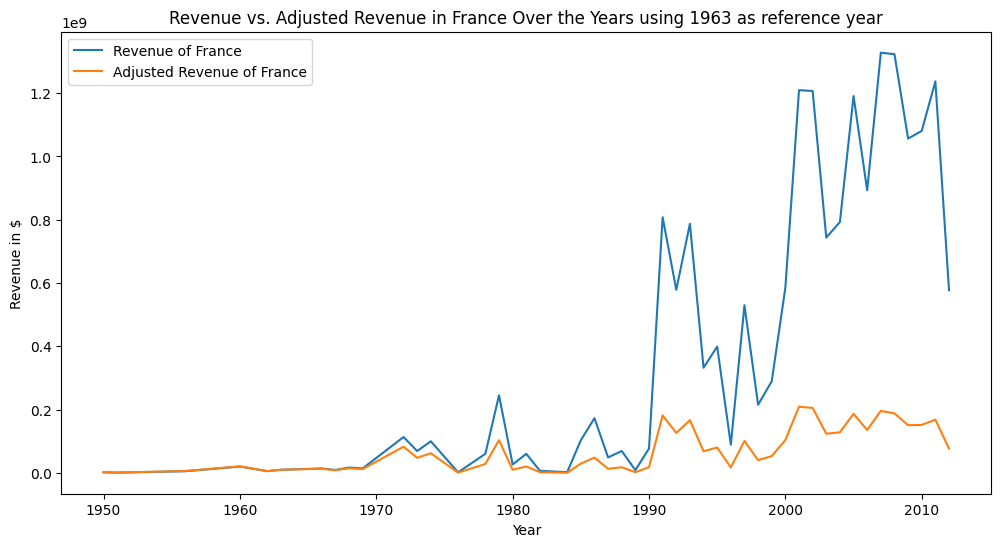

In [55]:
plot_revenue_vs_adjusted_revenue(df_movies_eco_exploded_countries, 'France')

In [56]:
import plotly.graph_objects as go

def interactive_revenue_plot(data):
    # Initialize figure
    fig = go.Figure()
    data['countries'] = data['countries'].astype(str)
    # Add traces for each country's data
    for country in data['countries'].unique():
        country_data = data[data['countries'] == country].groupby('year', as_index = False)[['revenue','revenue_adj']].sum()
        
        # Add Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue'],
            mode='lines',
            name=f'Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False
        ))

        # Add Adjusted Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue_adj'],
            mode='lines',
            name=f'Adjusted Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False
        ))

    # Create dropdown buttons for filtering by country
    buttons = []
    for country in data['countries'].unique():
         # Ensure trace names are strings for comparison
        visibility = [country in str(trace.name) for trace in fig.data]
        
        button = {
            'label': country,
            'method': 'update',
            'args': [
                {'visible': visibility},
                {'title': f"Revenue vs Adjusted Revenue: {country}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
        }],
        title="Revenue vs Adjusted Revenue Over the Years",
        xaxis_title='Year',
        yaxis_title='Revenue in $',
    )

    # Show the figure
    fig.show()

# Example Usage:
# Assuming `df` is a DataFrame with columns ['Year', 'Country', 'Revenue']
# df = pd.DataFrame({...})
# interactive_revenue_plot(df)


In [57]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [58]:
interactive_revenue_plot(df_movies_eco_exploded_countries)

In [ ]:
import plotly.graph_objects as go

def interactive_revenue_plot_country(data):
    # Initialize figure
    fig = go.Figure()
    data['countries'] = data['countries'].astype(str)

    # Add traces for each country's data
    for i, country in enumerate(data['countries'].unique()):
        country_data = data[data['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

        # Add Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue'],
            mode='lines+markers',
            name=f'Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='circle'),
            yaxis='y'  # Use the primary y-axis
        ))

        # Add Adjusted Revenue trace
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue_adj'],
            mode='lines+markers',
            name=f'Adjusted Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='square'),
            yaxis='y2'  # Use the secondary y-axis
        ))

    # Create dropdown buttons for filtering by country
    buttons = []
    for country in data['countries'].unique():
        visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

        button = {
            'label': country,
            'method': 'update',
            'args': [
                {'visible': visibility},  # Update visibility of traces
                {'title': f"Revenue vs Adjusted Revenue: {country}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu and styling
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'y': 1.15,
            'xanchor': 'center',
            'yanchor': 'top'
        }],
        title={
            'text': "Revenue vs Adjusted Revenue Over the Years",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial, sans-serif')
        },
        xaxis=dict(
            title='Year',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis2=dict(
            title='Adjusted Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            overlaying='y',
            side='right',
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        legend=dict(
            title='Legend',
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=12)
        ),
        plot_bgcolor='white'
    )

    # Add grid lines and background
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

    # Show the figure
    fig.show()


In [112]:
df_movies_eco_exploded_countries.head(10)

wiki_id freebase_id              original_title release_date  \
0     975900   /m/03vyhn              Ghosts of Mars   2001-08-24   
7   10408933  /m/02qc0j7    Alexander's Ragtime Band   1938-08-16   
13    171005   /m/016ywb                     Henry V   1989-11-08   
17     77856    /m/0kcn7                Mary Poppins   1964-08-27   
21    612710   /m/02wjqm              New Rose Hotel   1999-10-01   
29    156558   /m/014k4y                    Baby Boy   2001-06-27   
36   1364293   /m/04wy0v  They Knew What They Wanted   1940-01-01   
49    261237   /m/01mrrd      The Gods Must Be Crazy   1980-01-01   
53  12008535  /m/02vlsqt                Rudo y Cursi   2008-01-01   
53  12008535  /m/02vlsqt                Rudo y Cursi   2008-01-01   

        revenue  runtime                               languages  \
0    14010832.0     98.0                      [English Language]   
7     3600000.0    106.0                      [English Language]   
13   10161099.0    137.0                      [English Language]   
17  102272727.0    139.0                      [English Language]   
21      21521.0     92.0                      [English Language]   
29   29381649.0    123.0                      [English Language]   
36     932000.0     96.0                      [English Language]   
49   34331783.0    109.0  [Afrikaans Language, English Language]   
53   11091868.0    103.0                      [Spanish Language]   
53   11091868.0    103.0                      [Spanish Language]   

                   countries  \
0   United States of America   
7   United States of America   
13            United Kingdom   
17  United States of America   
21  United States of America   
29  United States of America   
36  United States of America   
49              South Africa   
53                    Mexico   
53  United States of America   

                                               genres   countries_freebase_id  \
0   [Thriller, Science Fiction, Horror, Adventure,...             [/m/09c7w0]   
7                  [Musical, Comedy, Black-and-white]             [/m/09c7w0]   
13  [Costume drama, War film, Epic, Period piece, ...              [/m/07ssc]   
17  [Children's/Family, Musical, Fantasy, Comedy, ...             [/m/09c7w0]   
21  [Thriller, Science Fiction, Future noir, Indie...             [/m/09c7w0]   
29              [Crime Fiction, Drama, Coming of age]             [/m/09c7w0]   
36  [Romance Film, Marriage Drama, Drama, Black-an...             [/m/09c7w0]   
49  [Adventure, Action/Adventure, Indie, World cin...              [/m/0hzlz]   
53  [Sports, Drama, Family Drama, Comedy-drama, Co...  [/m/0b90_r, /m/09c7w0]   
53  [Sports, Drama, Family Drama, Comedy-drama, Co...  [/m/0b90_r, /m/09c7w0]   

    languages_freebase_id                                 genres_freebase_id  \
0            [/m/02h40lc]  [/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...   
7            [/m/02h40lc]                    [/m/04t36, /m/01z4y, /m/01g6gs]   
13           [/m/02h40lc]  [/m/04xvh5, /m/082gq, /m/06l3bl, /m/04xvlr, /m...   
17           [/m/02h40lc]  [/m/0hj3myq, /m/04t36, /m/01hmnh, /m/01z4y, /m...   
21           [/m/02h40lc]  [/m/01jfsb, /m/06n90, /m/0279xh5, /m/0219x_, /...   
29           [/m/02h40lc]                  [/m/0lsxr, /m/07s9rl0, /m/01j1n2]   
36           [/m/02h40lc]     [/m/02l7c8, /m/0hj3nbk, /m/07s9rl0, /m/01g6gs]   
49  [/m/0x82, /m/02h40lc]  [/m/03k9fj, /m/03btsm8, /m/0219x_, /m/03q4nz, ...   
53             [/m/06nm1]  [/m/01z02hx, /m/07s9rl0, /m/02h8pkk, /m/01t_vv...   
53             [/m/06nm1]  [/m/01z02hx, /m/07s9rl0, /m/02h8pkk, /m/01t_vv...   

      year   revenue_adj         region  
0   2001.0  2.423278e+06  North America  
7   1938.0  7.823773e+06  North America  
13  1989.0  2.510220e+06         Europe  
17  1964.0  1.009813e+08  North America  
21  1999.0  3.956660e+03  North America  
29  2001.0  5.081775e+06  North America  
36  1940.0  2.037537e+06  North America  
49  1980.0  1.275855e+07         A

In [121]:
interactive_revenue_plot_country(df_movies_eco_exploded_countries)

Let's create an interactive plot to select regions

In [61]:
def attachWorldRegion(country):
    # Load countries dictionnary
    with open('././data/freebaseIdDictionnaries/regions', 'r') as file:
        countries_regions = json.load(file)
    
    # Convert country to string
    country = str(country)
    
    # Attach a world region to each country
    world_region = countries_regions[country]
    
    return world_region

In [62]:
df_movies_eco_exploded_countries['region'] = df_movies_eco_exploded_countries['countries'].apply(attachWorldRegion)

In [63]:
import plotly.graph_objects as go

def interactive_revenue_plot_region(data):
    # Initialize figure
    fig = go.Figure()
    data['region'] = data['region'].astype(str)

    # Define colors for consistent styling
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']

    # Add traces for each region's data
    for i, region in enumerate(data['region'].unique()):
        region_data = data[data['region'] == region].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

        # Assign colors dynamically
        color = colors[i % len(colors)]

        # Add Revenue trace
        fig.add_trace(go.Scatter(
            x=region_data['year'],
            y=region_data['revenue'],
            mode='lines+markers',
            name=f'Revenue ({region})',
            visible=True if region == data['region'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='circle'),
            yaxis='y'  # Use the primary y-axis
        ))

        # Add Adjusted Revenue trace
        fig.add_trace(go.Scatter(
            x=region_data['year'],
            y=region_data['revenue_adj'],
            mode='lines+markers',
            name=f'Adjusted Revenue ({region})',
            visible=True if region == data['region'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='square'),
            yaxis='y2'  # Use the secondary y-axis
        ))

    # Create dropdown buttons for filtering by region
    buttons = []
    for region in data['region'].unique():
        visibility = [region == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

        button = {
            'label': region,
            'method': 'update',
            'args': [
                {'visible': visibility},  # Update visibility of traces
                {'title': f"Revenue vs Adjusted Revenue: {region}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu and styling
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'y': 1.15,
            'xanchor': 'center',
            'yanchor': 'top'
        }],
        title={
            'text': "Revenue vs Adjusted Revenue Over the Years",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial, sans-serif')
        },
        xaxis=dict(
            title='Year',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis2=dict(
            title='Adjusted Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            overlaying='y',
            side='right',
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        legend=dict(
            title='Legend',
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=12)
        ),
        plot_bgcolor='white'
    )

    # Add grid lines and background
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

    # Show the figure
    fig.show()


In [64]:
interactive_revenue_plot_region(df_movies_eco_exploded_countries)

In [65]:
df_movies_eco_exploded_countries.head()

wiki_id freebase_id            original_title release_date      revenue  \
0     975900   /m/03vyhn            Ghosts of Mars   2001-08-24   14010832.0   
7   10408933  /m/02qc0j7  Alexander's Ragtime Band   1938-08-16    3600000.0   
13    171005   /m/016ywb                   Henry V   1989-11-08   10161099.0   
17     77856    /m/0kcn7              Mary Poppins   1964-08-27  102272727.0   
21    612710   /m/02wjqm            New Rose Hotel   1999-10-01      21521.0   

    runtime           languages                 countries  \
0      98.0  [English Language]  United States of America   
7     106.0  [English Language]  United States of America   
13    137.0  [English Language]            United Kingdom   
17    139.0  [English Language]  United States of America   
21     92.0  [English Language]  United States of America   

                                               genres countries_freebase_id  \
0   [Thriller, Science Fiction, Horror, Adventure,...           [/m/09c7w0]   
7                  [Musical, Comedy, Black-and-white]           [/m/09c7w0]   
13  [Costume drama, War film, Epic, Period piece, ...            [/m/07ssc]   
17  [Children's/Family, Musical, Fantasy, Comedy, ...           [/m/09c7w0]   
21  [Thriller, Science Fiction, Future noir, Indie...           [/m/09c7w0]   

   languages_freebase_id                                 genres_freebase_id  \
0           [/m/02h40lc]  [/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...   
7           [/m/02h40lc]                    [/m/04t36, /m/01z4y, /m/01g6gs]   
13          [/m/02h40lc]  [/m/04xvh5, /m/082gq, /m/06l3bl, /m/04xvlr, /m...   
17          [/m/02h40lc]  [/m/0hj3myq, /m/04t36, /m/01hmnh, /m/01z4y, /m...   
21          [/m/02h40lc]  [/m/01jfsb, /m/06n90, /m/0279xh5, /m/0219x_, /...   

      year   revenue_adj         region  
0   2001.0  2.423278e+06  North America  
7   1938.0  7.823773e+06  North America  
13  1989.0  2.510220e+06         Europe  
17  1964.0  1.009813e+08  North America  
21  1999.0  3.956660e+03  North America

Now I want to create an interactive map that shows the market share of each country worldwide depending on the year.

In [196]:
# Group by Year and Country, sum revenue
df_movies_eco_exploded_countries_agg = df_movies_eco_exploded_countries.groupby(["year", "countries"])["revenue"].sum().reset_index()

# Calculate total revenue per year
df_movies_eco_exploded_countries_agg["total_revenue_year"] = df_movies_eco_exploded_countries_agg.groupby("year")["revenue"].transform("sum")

# Calculate market share
df_movies_eco_exploded_countries_agg["market_share"] = df_movies_eco_exploded_countries_agg["revenue"] / df_movies_eco_exploded_countries_agg["total_revenue_year"] *100

df_movies_eco_exploded_countries_agg['log_revenue'] = df_movies_eco_exploded_countries_agg["revenue"].apply(lambda x: np.log(x))

df_movies_eco_exploded_countries_agg["log_market_share"] = df_movies_eco_exploded_countries_agg["market_share"].apply(lambda x: np.log(x))

df_movies_eco_exploded_countries_agg['year'] = df_movies_eco_exploded_countries_agg['year'].astype(int)

df_movies_eco_exploded_countries_agg.head()

year                 countries     revenue  total_revenue_year  \
0  1914  United States of America   2831728.0           2831728.0   
1  1915  United States of America  50000000.0          50000000.0   
2  1920  United States of America   4500000.0           4500000.0   
3  1921  United States of America   7900000.0           7900000.0   
4  1922  United States of America  17530973.0          17530973.0   

   market_share  log_revenue  log_market_share  
0         100.0    14.856398           4.60517  
1         100.0    17.727534           4.60517  
2         100.0    15.319588           4.60517  
3         100.0    15.882373           4.60517  
4         100.0    16.679480           4.60517

In [146]:
df_movies_eco_exploded_countries_agg["log_market_share"].describe()

count    908.000000
mean      -0.817004
std        2.993238
min      -10.183469
25%       -2.802404
50%       -0.782555
75%        1.149414
max        4.605170
Name: log_market_share, dtype: float64

In [147]:
import pandas as pd
import plotly.express as px

# Create the choropleth map
fig = px.choropleth(
    df_movies_eco_exploded_countries_agg,
    locations="countries",  # Column with country names
    locationmode="country names",  # If ISO codes, use "ISO-3" here
    color="log_market_share",  # Data for color intensity
    animation_frame="year",  # Add animation by year
    color_continuous_scale="Blues",  # Color scale
    range_color=[df_movies_eco_exploded_countries_agg["log_market_share"].min(), df_movies_eco_exploded_countries_agg["log_market_share"].max()],  # Fix scale range to min and max market share
    title="Market Share in terms of Revenue Worldwide per Year"
)

# Improve layout (optional)
fig.update_layout(
    geo=dict(
        showframe=False,
        projection_type='equirectangular'
    ),
    title_x=0.5  # Center title
)

# Show the figure
fig.show()


On a montré que les parts du marché mondial du cinéma se sont peu à peu diversifiées ce qui témoigne d'une économie mondiale du cinéma qui s'est mondialisée

### III.3 Co-productions evolution

Another interesting point is to test potential correlation between co-productions box office revenue by analyzing the revenue of film industry over time depending on the number of co-productions.

Pour faire cela on va compter le nombre de co productions par pays puis représenter le revenue du pays au cours des années avec en fond un stack bar chart qui va montrer le nombre de co productions

On cherche donc à calculer par années, le nombre de co-productions de chaque pays

On crée un dataframe avec tous les wiki_id des films co produits

In [88]:
df_movies_eco_coprod = df_movies_eco_exploded_countries.groupby(["wiki_id"])["countries"].count().reset_index()

df_movies_eco_coprod = df_movies_eco_coprod[df_movies_eco_coprod["countries"] > 1]

df_movies_eco_coprod.countries.value_counts()

countries
2     1283
3      399
4      143
5       27
6       12
7        4
11       2
8        2
13       1
10       1
Name: count, dtype: int64

On filtre notre dataframe pour garder que les films co produits

In [91]:
df_movies_eco_exploded_countries_coprod = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries["wiki_id"].isin(df_movies_eco_coprod["wiki_id"])]
df_movies_eco_exploded_countries_coprod.head()

wiki_id freebase_id        original_title release_date     revenue  \
53   12008535  /m/02vlsqt          Rudo y Cursi   2008-01-01  11091868.0   
53   12008535  /m/02vlsqt          Rudo y Cursi   2008-01-01  11091868.0   
164   1031231   /m/03_wh5  Black Cat, White Cat   1998-09-10    351447.0   
164   1031231   /m/03_wh5  Black Cat, White Cat   1998-09-10    351447.0   
164   1031231   /m/03_wh5  Black Cat, White Cat   1998-09-10    351447.0   

     runtime                                          languages  \
53     103.0                                 [Spanish Language]   
53     103.0                                 [Spanish Language]   
164    135.0  [Romani language, Italian Language, Serbo-Croa...   
164    135.0  [Romani language, Italian Language, Serbo-Croa...   
164    135.0  [Romani language, Italian Language, Serbo-Croa...   

                    countries  \
53                     Mexico   
53   United States of America   
164                    France   
164                  Slovenia   
164                   Germany   

                                                genres  \
53   [Sports, Drama, Family Drama, Comedy-drama, Co...   
53   [Sports, Drama, Family Drama, Comedy-drama, Co...   
164  [Romantic comedy, Comedy, Music, Comedy of Err...   
164  [Romantic comedy, Comedy, Music, Comedy of Err...   
164  [Romantic comedy, Comedy, Music, Comedy of Err...   

               countries_freebase_id  \
53            [/m/0b90_r, /m/09c7w0]   
53            [/m/0b90_r, /m/09c7w0]   
164  [/m/0f8l9c, /m/087vz, /m/0345h]   
164  [/m/0f8l9c, /m/087vz, /m/0345h]   
164  [/m/0f8l9c, /m/087vz, /m/0345h]   

                                 languages_freebase_id  \
53                                          [/m/06nm1]   
53                                          [/m/06nm1]   
164  [/m/012psb, /m/02bjrlw, /m/06x8y, /m/01bkv, /m...   
164  [/m/012psb, /m/02bjrlw, /m/06x8y, /m/01bkv, /m...   
164  [/m/012psb, /m/02bjrlw, /m/06x8y, /m/01bkv, /m...   

                                    genres_freebase_id    year   revenue_adj  \
53   [/m/01z02hx, /m/07s9rl0, /m/02h8pkk, /m/01t_vv...  2008.0  1.577726e+06   
53   [/m/01z02hx, /m/07s9rl0, /m/02h8pkk, /m/01t_vv...  2008.0  1.577726e+06   
164  [/m/06cvj, /m/01z4y, /m/04rlf, /m/0hj3mz5, /m/...  1998.0  6.602769e+04   
164  [/m/06cvj, /m/01z4y, /m/04rlf, /m/0hj3mz5, /m/...  1998.0  6.602769e+04   
164  [/m/06cvj, /m/01z4y, /m/04rlf, /m/0hj3mz5, /m/...  1998.0  6.602769e+04   

            region  
53   North America  
53   North America  
164         Europe  
164         Europe  
164         Europe

On crée un dataframe qui va par année déterminer le nombre de coproduction de chaque pays

In [148]:
# Comptage des co-productions par année et par pays
df_movies_eco_coprod_countries_count = (df_movies_eco_exploded_countries_coprod.groupby(["year", "countries"])["wiki_id"].nunique().reset_index(name="co_production_count"))
df_movies_eco_coprod_countries_count['year'] = df_movies_eco_coprod_countries_count['year'].astype(int)
df_movies_eco_coprod_countries_count.head(100)

year                 countries  co_production_count
0   1925            United Kingdom                    1
1   1925  United States of America                    1
2   1930                   Germany                    1
3   1940                  Malaysia                    1
4   1940  United States of America                    1
..   ...                       ...                  ...
95  1973  United States of America                    3
96  1974                 Australia                    1
97  1974                     Italy                    1
98  1974               New Zealand                    1
99  1974               Philippines                    1

[100 rows x 3 columns]

In [149]:
import plotly.graph_objects as go

def interactive_revenue_plot_coprod(data, data2):
    # Initialize figure
    fig = go.Figure()
    data['countries'] = data['countries'].astype(str)

    # Add traces for each country's data
    for i, country in enumerate(data['countries'].unique()):
        country_data = data[data['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

        # Add Bar trace (with transparency)
        fig.add_trace(go.Bar(
            x=country_data['year'],
            y=data2['co_production_count'],  # Count of co-productions
            name=f'Co-productions ({country})',
            marker=dict(opacity=0.5),
            visible=True if country == data['countries'].unique()[0] else False,
            yaxis='y2'  # Use the primary y-axis
        ))

        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data['revenue_adj'],
            mode='lines+markers',
            name=f'Adjusted Revenue ({country})',
            visible=True if country == data['countries'].unique()[0] else False,
            line=dict(width=2),
            marker=dict(size=6, symbol='square'),
            yaxis='y'  # Use the secondary y-axis
        ))

    # Create dropdown buttons for filtering by country
    buttons = []
    for country in data['countries'].unique():
        visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

        button = {
            'label': country,
            'method': 'update',
            'args': [
                {'visible': visibility},  # Update visibility of traces
                {'title': f"Revenue vs Adjusted Revenue: {country}"}
            ]
        }
        buttons.append(button)

    # Update layout with dropdown menu and styling
    fig.update_layout(
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.5,
            'y': 1.15,
            'xanchor': 'center',
            'yanchor': 'top'
        }],
        title={
            'text': "Revenue vs Adjusted Revenue Over the Years",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, family='Arial, sans-serif')
        },
        xaxis=dict(
            title='Year',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis=dict(
            title='Adjusted Revenue',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            overlaying='y2',
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        yaxis2=dict(
            title='# Co-Productions',
            titlefont=dict(size=16),
            tickfont=dict(size=12),
            side='right',
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=False
        ),
        legend=dict(
            title='Legend',
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1,
            font=dict(size=12)
        ),
        plot_bgcolor='white'
    )

    # Add grid lines and background
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

    # Show the figure
    fig.show()


In [150]:
interactive_revenue_plot_coprod(df_movies_eco_exploded_countries, df_movies_eco_coprod_countries_count)

On va créer un dataframe qui par année va déterminer les couples de pays et le nombre de co productions

In [151]:
from itertools import combinations

# Étape 1 : Grouper les pays de co-production par film et année
df_movies_eco_coprod_countries = df_movies_eco_exploded_countries_coprod.groupby(["wiki_id", "year"])["countries"].apply(list).reset_index()

# Étape 2 : Générer toutes les combinaisons de pays pour chaque film
def generate_country_combinations(row):
    return pd.DataFrame(list(combinations(sorted(row["countries"]), 2)), columns=["country_1", "country_2"]).assign(year=row["year"])

combinations_df = pd.concat([generate_country_combinations(row) for _, row in df_movies_eco_coprod_countries.iterrows()], ignore_index=True)

# Étape 3 : Compter les co-productions par année et par paire de pays
df_movies_eco_coprod_country_country = (
    combinations_df.groupby(["year", "country_1", "country_2"])
    .size()
    .reset_index(name="co_production_count")
)

df_movies_eco_coprod_country_country['year'] = df_movies_eco_coprod_country_country['year'].astype(int)
df_movies_eco_coprod_country_country.head()

year       country_1                 country_2  co_production_count
0  1925  United Kingdom  United States of America                    1
1  1930         Germany                   Germany                    1
2  1940        Malaysia  United States of America                    1
3  1942  United Kingdom  United States of America                    1
4  1945  United Kingdom            United Kingdom                    1

In [ ]:
# plotting the map with a slider
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd

# charging geographical data 
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# changing data into the right projection to compute the centroids
world_projected = world.to_crs("EPSG:3395")
world_projected["centroid"] = world_projected.geometry.centroid
world["centroid"] = world_projected["centroid"].to_crs(world.crs) # converting back the centroids into the right projection

# Linking each centroid with a country
centroids = world.set_index("NAME")["centroid"] 
df_movies_eco_coprod_country_country["coord1"] = df_movies_eco_coprod_country_country["country_1"].map(centroids)
df_movies_eco_coprod_country_country["coord2"] = df_movies_eco_coprod_country_country["country_2"].map(centroids)

#Fixing centroid of USA (without Alaska), Canada, Norway and France
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'United States of America', 'coord1'] = Point(-98.35, 39.50)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'United States of America', 'coord2'] = Point(-98.35, 39.50)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'Canada', 'coord1'] = Point(-105, 56.8)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'Canada', 'coord2'] = Point(-105, 56.8)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'Norway', 'coord1'] = Point(10, 62)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'Norway', 'coord2'] = Point(10, 62)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'France', 'coord1'] = Point(2.25, 46.32)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'France', 'coord2'] = Point(2.25, 46.32)

# Creating the figure
fig = px.scatter_geo(
    world,  # GeoDataFrame
    #locations="ISO_A3",  # countries id
    #hover_name="NAME",  # names to print
    title="Co-productions Between Countries Over the Years",
    
)

# Adding the links from links_occurence df
traces = []
for year in df_movies_eco_coprod_country_country["year"].unique():
    df_year = df_movies_eco_coprod_country_country[df_movies_eco_coprod_country_country["year"] == year]
    df_year = df_year.dropna(subset=["coord1", "coord2"])

    trace = px.scatter_geo(
        world,  # Carte de base
        locations="ISO_A3",
        hover_name="NAME",
        title=f"Interactions between countries ({year})"
    )
    for _, row in df_year.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=row["co_production_count"] / 30, color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({row['year']})",
            opacity=1,
            showlegend=False
        )

    traces.append(trace)

# Adding a slider and centering the title
fig.update_layout(
    showlegend=False, 
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": "Year: "},
            pad={"t": 50},
            steps=[
                dict(
                    label=str(year),
                    method="update",
                    args=[{"visible": [i <= idx for i in range(len(traces))]}],
                )
                for idx, year in enumerate(df_movies_eco_coprod_country_country["year"].unique())
            ],
        )
    ],
    width=1000,
    height=800,
    title={
        "text": "Co-productions Between Countries Over the Years",  # Titre du graphique
        "x": 0.5,  # Centre le titre (0 = gauche, 1 = droite)
        "xanchor": "center",  # Ancrage horizontal
        "yanchor": "top"  # Ancrage vertical
    }
)

fig.show()



In [ ]:
import plotly.express as px
import geopandas as gpd
import pandas as pd

# Chargement des données géographiques
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# Données de revenus du cinéma par pays et par année
# Exemple de structure pour le DataFrame des revenus (df_revenues)
# df_revenues = pd.DataFrame({
#     "country": ["France", "United States of America", "Germany", ...],
#     "year": [2020, 2020, 2020, ...],
#     "revenue": [1000, 5000, 1200, ...]  # Revenus en millions, par exemple
# })

# Agréger les revenus pour chaque pays (assurez-vous que l'index est unique)
df_revenues = df_movies_eco_exploded_countries_agg.groupby('countries', as_index=False)['log_revenue'].mean()  # ou .mean()

# Lier les données des revenus au GeoDataFrame des pays
world['revenue'] = world['NAME'].map(df_revenues.set_index('countries')['log_revenue'])

# Création de la carte de base avec Plotly
fig = px.scatter_geo(
    world, 
    locations="ISO_A3",  # Code pays ISO3
    hover_name="NAME", 
    title="Co-productions Between Countries Over the Years"
)

# Ajouter les cercles représentant la taille du marché du cinéma
for _, row in world.iterrows():
    if pd.notna(row['revenue']):  # Assurez-vous qu'il y a des données de revenu
        fig.add_scattergeo(
            lon=[row['geometry'].centroid.x],
            lat=[row['geometry'].centroid.y],
            mode='markers',
            marker=dict(
                size=row['revenue'] / 50,  # Taille du cercle proportionnelle au revenu
                color='blue',  # Couleur des cercles
                opacity=0.6,
                line=dict(width=1, color='black')  # Contour noir pour les cercles
            ),
            hovertemplate=f"{row['NAME']}<br>Revenue: {row['revenue']}<br><extra></extra>",  # Info au survol
        )

# Ajouter les liens entre les pays (reste inchangé)
for year in df_movies_eco_coprod_country_country["year"].unique():
    df_year = df_movies_eco_coprod_country_country[df_movies_eco_coprod_country_country["year"] == year]
    df_year = df_year.dropna(subset=["coord1", "coord2"])

    for _, row in df_year.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=row["co_production_count"] / 30, color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({row['year']})",
            opacity=0.8,
        )

# Mise à jour de la mise en page avec un slider pour les années
fig.update_layout(
    showlegend=False,
    sliders=[dict(
        active=0,
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        steps=[
            dict(
                label=str(year),
                method="update",
                args=[{"visible": [i <= idx for i in range(len(traces))]}],
            )
            for idx, year in enumerate(df_movies_eco_coprod_country_country["year"].unique())
        ],
    )],
    width=1000,
    height=800,
    title={
        "text": "Co-productions Between Countries Over the Years",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top"
    }
)

fig.show()


In [206]:
from itertools import combinations
import pandas as pd

# Étape 1 : Grouper les pays de co-production par film et année
df_movies_eco_coprod_countries = df_movies_eco_exploded_countries_coprod.groupby(["wiki_id", "year"])["countries"].apply(list).reset_index()

# Étape 2 : Générer toutes les combinaisons de pays pour chaque film
def generate_country_combinations(row):
    return pd.DataFrame(list(combinations(sorted(row["countries"]), 2)), columns=["country_1", "country_2"]).assign(year=row["year"])

combinations_df = pd.concat([generate_country_combinations(row) for _, row in df_movies_eco_coprod_countries.iterrows()], ignore_index=True)

# Étape 3 : Ajouter la tranche de 5 ans à l'année
combinations_df['period'] = (combinations_df['year'] // 5) * 5

# Étape 4 : Compter les co-productions par tranche de 5 ans et par paire de pays
df_movies_eco_coprod_country_country_5 = (
    combinations_df.groupby(["period", "country_1", "country_2"])
    .size()
    .reset_index(name="co_production_count")
)

df_movies_eco_coprod_country_country_5['period'] = df_movies_eco_coprod_country_country_5['period'].astype(int)
df_movies_eco_coprod_country_country_5.head()


period       country_1                 country_2  co_production_count
0    1925  United Kingdom  United States of America                    1
1    1930         Germany                   Germany                    1
2    1940        Malaysia  United States of America                    1
3    1940  United Kingdom  United States of America                    1
4    1945  United Kingdom            United Kingdom                    1

In [228]:
import numpy as np
import pandas as pd

# Group by Year and Country, sum revenue
df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries.groupby(["year", "countries"])["revenue"].sum().reset_index()

# Create period based on 5-year intervals
df_movies_eco_exploded_countries_agg_5['period'] = (df_movies_eco_exploded_countries_agg_5['year'] // 5) * 5

# Calculate total revenue per period
df_movies_eco_exploded_countries_agg_5["total_revenue_period"] = df_movies_eco_exploded_countries_agg_5.groupby("period")["revenue"].transform("sum")


# Calculate log of revenue over the period
df_movies_eco_exploded_countries_agg_5['log_total_revenue_period'] = df_movies_eco_exploded_countries_agg_5["total_revenue_period"].apply(lambda x: np.log(x) if x > 0 else 0)

# Convert year to integer (if not already)
df_movies_eco_exploded_countries_agg_5['year'] = df_movies_eco_exploded_countries_agg_5['year'].astype(int)

# Convert year to integer (if not already)
df_movies_eco_exploded_countries_agg_5['period'] = df_movies_eco_exploded_countries_agg_5['period'].astype(int)


df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries != "Republic of Serbia"]

df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries != "The Bahamas"]

df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries != "Bosnia and Herzegovina"]

# Show the result
df_movies_eco_exploded_countries_agg_5.head()


year                 countries     revenue  period  total_revenue_period  \
0  1914  United States of America   2831728.0    1910             2831728.0   
1  1915  United States of America  50000000.0    1915            50000000.0   
2  1920  United States of America   4500000.0    1920            40019590.0   
3  1921  United States of America   7900000.0    1920            40019590.0   
4  1922  United States of America  17530973.0    1920            40019590.0   

   log_total_revenue_period  
0                 14.856398  
1                 17.727534  
2                 17.504880  
3                 17.504880  
4                 17.504880

In [224]:
df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries == "Republic of Serbia"]

Empty DataFrame
Columns: [year, countries, revenue, period, total_revenue_period, log_total_revenue_period]
Index: []

In [234]:
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# Chargement des données géographiques
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# Changement de projection pour calculer les centroïdes
world_projected = world.to_crs("EPSG:3395")
world_projected["centroid"] = world_projected.geometry.centroid
world["centroid"] = world_projected["centroid"].to_crs(world.crs)  # Conversion des centroïdes dans la bonne projection

# Liaison de chaque centroïde avec un pays
centroids = world.set_index("NAME")["centroid"]

df_movies_eco_coprod_country_country_5["coord1"] = df_movies_eco_coprod_country_country_5["country_1"].map(centroids)
df_movies_eco_coprod_country_country_5["coord2"] = df_movies_eco_coprod_country_country_5["country_2"].map(centroids)

# Correction des centroïdes pour certains pays
df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_1'] == 'United States of America', 'coord1'] = Point(-98.35, 39.50)
df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_2'] == 'United States of America', 'coord2'] = Point(-98.35, 39.50)

df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_1'] == 'Canada', 'coord1'] = Point(-105, 56.8)
df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_2'] == 'Canada', 'coord2'] = Point(-105, 56.8)

df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_1'] == 'Norway', 'coord1'] = Point(10, 62)
df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_2'] == 'Norway', 'coord2'] = Point(10, 62)

df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_1'] == 'France', 'coord1'] = Point(2.25, 46.32)
df_movies_eco_coprod_country_country_5.loc[df_movies_eco_coprod_country_country_5['country_2'] == 'France', 'coord2'] = Point(2.25, 46.32)


# Correction des centroïdes pour certains pays
df_movies_eco_exploded_countries_agg_5.loc[df_movies_eco_exploded_countries_agg_5['countries'] == 'United States of America', 'coord1'] = Point(-98.35, 39.50)

df_movies_eco_exploded_countries_agg_5.loc[df_movies_eco_exploded_countries_agg_5['countries'] == 'Canada', 'coord1'] = Point(-105, 56.8)

df_movies_eco_exploded_countries_agg_5.loc[df_movies_eco_exploded_countries_agg_5['countries'] == 'Norway', 'coord1'] = Point(10, 62)

df_movies_eco_exploded_countries_agg_5.loc[df_movies_eco_exploded_countries_agg_5['countries'] == 'France', 'coord1'] = Point(2.25, 46.32)

# Création de la figure
fig = px.scatter_geo(
    world,  # GeoDataFrame
    title="Co-productions Between Countries Over the Years",
)

# Ajout des liens de co-production
traces = []
for period in df_movies_eco_coprod_country_country_5["period"].unique():
    df_period = df_movies_eco_coprod_country_country_5[df_movies_eco_coprod_country_country_5["period"] == period]
    df_period = df_period.dropna(subset=["coord1", "coord2"])

    trace = px.scatter_geo(
        world,  # Carte de base
        locations="ISO_A3",
        hover_name="NAME",
        title=f"Interactions between countries ({period})"
    )
    for _, row in df_period.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=row["co_production_count"] / 30, color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({row['period']})",
            opacity=1,
            showlegend=False
        )

    # Ajout des bulles de revenu
    df_revenue_period = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5["period"] == period]
    for _, row in df_revenue_period.iterrows():
        country_centroid = centroids[row["countries"]]
        fig.add_scattergeo(
            lon=[country_centroid.x],
            lat=[country_centroid.y],
            mode="markers",
            marker=dict(size=row["log_total_revenue_period"]/10, color="red", opacity=0.7),
            name=f"{row['countries']} ({row['period']})",
            showlegend=False
        )

    traces.append(trace)

# Ajout d'un slider et centrage du titre
fig.update_layout(
    showlegend=False,
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": "Year: "},
            pad={"t": 50},
            steps=[
                dict(
                    label=str(period),
                    method="update",
                    args=[{"visible": [i <= idx for i in range(len(traces))]}],
                )
                for idx, period in enumerate(df_movies_eco_coprod_country_country_5["period"].unique())
            ],
        )
    ],
    width=1000,
    height=800,
    title={
        "text": "Co-productions Between Countries Over the Years",  # Titre du graphique
        "x": 0.5,  # Centre le titre (0 = gauche, 1 = droite)
        "xanchor": "center",  # Ancrage horizontal
        "yanchor": "top"  # Ancrage vertical
    }
)

fig.show()


In [ ]:
# we group by freebase_id and for each we get the list of the production countries
countries_per_movie = df_movies_eco_exploded.groupby(df_movies_eco_exploded['freebase_id'])['countries'].unique()
df_countries_per_movie = pd.DataFrame(countries_per_movie)
df_countries_per_movie.head(10)

countries
freebase_id                                            
/m/011wtv                    [United States of America]
/m/011x_4                    [United States of America]
/m/011xg5                    [United States of America]
/m/011xrr                    [United States of America]
/m/011yd2                    [United States of America]
/m/011ydl         [United States of America, Australia]
/m/011yfd                      [France, Belgium, Italy]
/m/011yg9    [United States of America, United Kingdom]
/m/011yhm    [United States of America, United Kingdom]
/m/011ykb                    [United States of America]

From the previous revenue analysis and the dataframe of co-production countries we can state on the influence of co-productions on the revenue as a witness to globalization.

From the previous co-production dataframe, we can construct a co-occurrence matrix that records the number of movies co-produced by each pair of countries. For movies involving multiple countries, each unique country pair’s count is incremented by one. For single-country productions, only that country’s self-pair count increases by one. This matrix will be visualized in a heatmap to reveal the closeness between countries based on co-production frequency, with countries that co-produce more frequently highlighted.

Finally, the conclusion of the Economics part will be a geopandas map as described before that will show the evolution coproduction over time and the size of the film industry in each country.